# 3-Class Transformer Sentiment Pipeline

**High-level summary:**  
An end-to-end PyTorch Transformer pipeline that builds an enhanced tokenizer & vocabulary, defines a pre-layer-norm multi-head attention Transformer, trains with OneCycleLR & label smoothing on imbalanced data, evaluates with detailed metrics, and provides an inference utility for new text.

In [ ]:
# prompt: connect google drive

from google.colab import drive
drive.mount('/content/drive')

# prompt: load current directory

import os

os.chdir('/content/drive/My Drive/CS605-NLP-Project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


=== Yelp Train ===
Shape: (650000, 2)
label     int64
text     object
dtype: object


,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...



=== Yelp Test ===
Shape: (50000, 2)
label     int64
text     object
dtype: object


,label,text
0,0,I got 'new' tires from them and within two wee...
1,0,Don't waste your time. We had two different p...
2,0,All I can say is the worst! We were the only 2...
3,0,I have been to this restaurant twice and was d...
4,0,Food was NOT GOOD at all! My husband & I ate h...



=== USS ===
Shape: (29412, 6)
integrated_review            object
stars                         int64
name                         object
review                       object
publishedAtDate      datetime64[ns]
review_index                  int64
dtype: object


,integrated_review,stars,name,review,publishedAtDate,review_index
0,Nice lot if activities need entire day to cove...,4,user_0,Nice lot if activities need entire day to cove...,2025-05-23,0
1,Universal Studios Singapore offers an unforget...,5,user_1,Universal Studios Singapore offers an unforget...,2025-05-23,1
2,Mummy ride was great but cost way too much for...,2,user_2,Mummy ride was great but cost way too much for...,2025-05-23,2
3,We went there to enjoy the Minions. It's hot d...,4,user_3,We went there to enjoy the Minions. It's hot d...,2025-05-23,3
4,Universal Studio's famous Playland Singapore. ...,5,user_4,Universal Studio's famous Playland Singapore.,2025-05-23,4



Yelp Train missing values:
label    0
text     0
dtype: int64

Yelp Test missing values:
label    0
text     0
dtype: int64

USS missing values:
integrated_review    0
stars                0
name                 0
review               0
publishedAtDate      0
review_index         0
dtype: int64


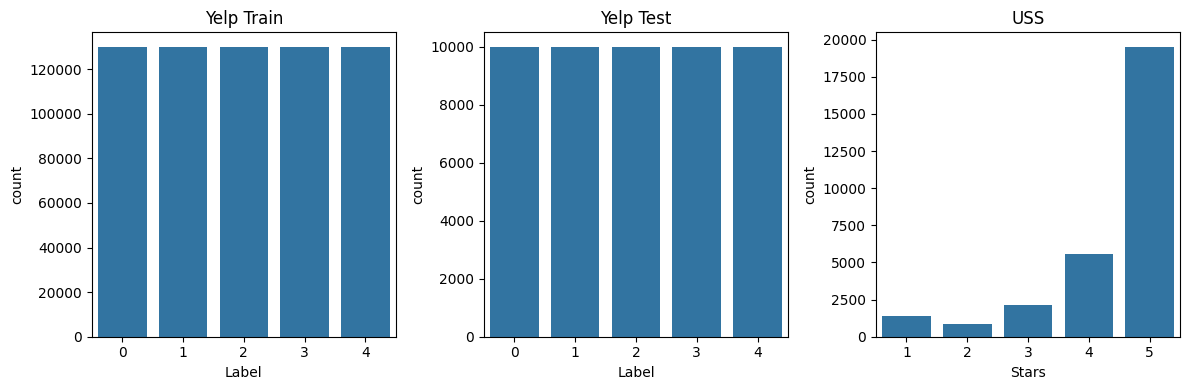

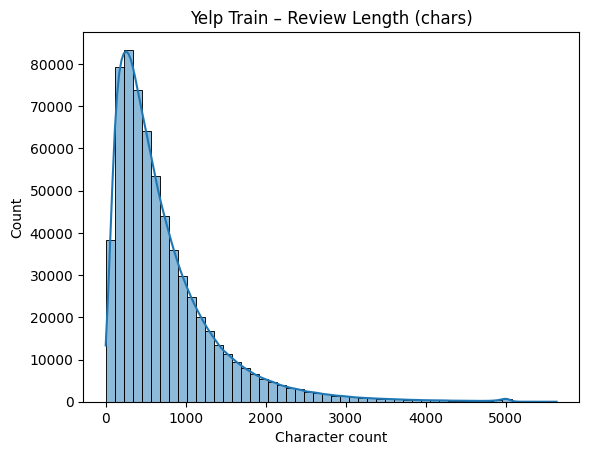

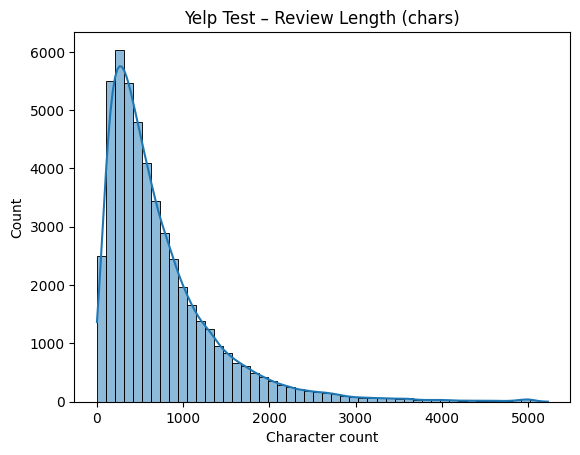

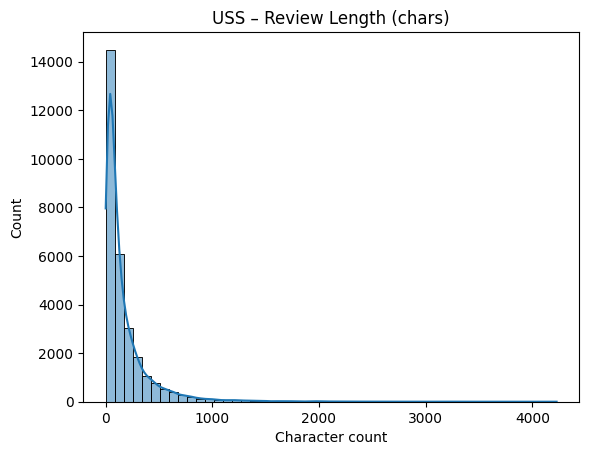

In [ ]:

#–– 1. Load your data  ––
yelp_train = pd.read_parquet("datastore/train-00000-of-00001.parquet")
yelp_test  = pd.read_parquet("datastore/test-00000-of-00001.parquet")
uss_reviews       = pd.read_csv("datastore/USS_Reviews_Silver.csv", parse_dates=["publishedAtDate"])

datasets = {
    "Yelp Train": yelp_train,
    "Yelp Test":  yelp_test,
    "USS":         uss_reviews
}

#–– 2. Quick look: shape, dtypes, head ––
for name, df in datasets.items():
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)
    print(df.dtypes)
    display(df.head())

#–– 3. Missing values ––
for name, df in datasets.items():
    print(f"\n{name} missing values:")
    print(df.isna().sum())

#–– 4. Rating distribution ––
plt.figure(figsize=(12,4))

for i, (name, df) in enumerate(datasets.items(), 1):
    # pick the correct column name for “stars/rating/label”
    possible_targets = ["stars", "rating", "label"]
    target_col = next(col for col in possible_targets if col in df.columns)

    plt.subplot(1, 3, i)
    sns.countplot(x=target_col, data=df)
    plt.title(name)
    plt.xlabel(target_col.capitalize())

plt.tight_layout()
plt.show()

#–– 5. Review‐length analysis ––
for name, df in datasets.items():
    # choose your text column
    text_col = "integrated_review" if "integrated_review" in df else "text"
    lengths = df[text_col].str.len()
    plt.figure()
    sns.histplot(lengths, bins=50, kde=True)
    plt.title(f"{name} – Review Length (chars)")
    plt.xlabel("Character count")
    plt.show()




In [ ]:
# Install required packages
#!pip install transformers datasets torch pandas scikit-learn accelerate


In [ ]:
#!pip install numpy==1.24.4
#!pip install --upgrade transformers

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import re
from collections import Counter
import math
import time

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ImprovedYelpDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length=384):  # Increased from 256
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Enhanced tokenization
        tokens = self.enhanced_tokenize(text)
        token_ids = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]

        # Pad or truncate
        if len(token_ids) > self.max_length:
            token_ids = token_ids[:self.max_length]
        else:
            token_ids += [self.vocab['<PAD>']] * (self.max_length - len(token_ids))

        return torch.tensor(token_ids, dtype=torch.long), torch.tensor(label, dtype=torch.long)

    def enhanced_tokenize(self, text):
        """Enhanced tokenization with better preprocessing"""
        # Convert to lowercase
        text = text.lower()

        # Handle contractions and common patterns
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"can't", "cannot", text)
        text = re.sub(r"n't", " not", text)
        text = re.sub(r"'re", " are", text)
        text = re.sub(r"'ve", " have", text)
        text = re.sub(r"'ll", " will", text)
        text = re.sub(r"'d", " would", text)
        text = re.sub(r"'m", " am", text)

        # Handle punctuation - keep some sentiment-relevant ones
        text = re.sub(r'[!]{2,}', ' very_excited ', text)  # Multiple exclamations
        text = re.sub(r'[?]{2,}', ' very_confused ', text)  # Multiple questions
        text = re.sub(r'[.]{3,}', ' continuation ', text)   # Ellipsis

        # Remove remaining punctuation except basic ones
        text = re.sub(r'[^a-zA-Z0-9\s!?.]', ' ', text)

        # Handle repeated characters (e.g., "soooo good" -> "so good")
        text = re.sub(r'(.)\1{2,}', r'\1\1', text)

        # Clean whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text.split()

def build_improved_vocab(texts, vocab_size=12000):  # Increased vocab size
    """Build improved vocabulary with better coverage"""
    print("Building improved vocabulary...")
    all_tokens = []

    # Use more texts for vocabulary if available
    if len(texts) > 200000:
        sample_texts = texts[::len(texts)//100000]  # Better sampling
        print(f"Sampling {len(sample_texts)} texts for vocabulary building")
    else:
        sample_texts = texts

    # Enhanced tokenization for vocab building
    dataset_temp = ImprovedYelpDataset(sample_texts, [0]*len(sample_texts), {}, 1)

    for text in sample_texts:
        tokens = dataset_temp.enhanced_tokenize(text)
        all_tokens.extend(tokens)

    # Count tokens and get most frequent
    token_counts = Counter(all_tokens)
    most_common = token_counts.most_common(vocab_size - 4)

    # Build vocabulary with special tokens
    vocab = {'<PAD>': 0, '<UNK>': 1, '<SOS>': 2, '<EOS>': 3}
    for token, count in most_common:
        if count >= 3:  # Minimum frequency threshold
            vocab[token] = len(vocab)

    print(f"Built vocabulary with {len(vocab)} tokens")
    return vocab

def calculate_class_weights(labels):
    """Calculate class weights for imbalanced datasets"""
    from sklearn.utils.class_weight import compute_class_weight
    import numpy as np

    classes = np.unique(labels)
    class_weights = compute_class_weight('balanced', classes=classes, y=labels)

    print("Class weights calculated:")
    for i, weight in enumerate(class_weights):
        print(f"  Class {i}: {weight:.4f}")

    return class_weights

class ImprovedMultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.size()

        # Store residual
        residual = x

        # Apply layer norm first (Pre-LN architecture)
        x = self.layer_norm(x)

        # Linear transformations and reshape
        Q = self.w_q(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.w_k(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.w_v(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, -1e9)

        attention_weights = torch.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        context = torch.matmul(attention_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)

        output = self.w_o(context)

        # Residual connection
        return residual + self.dropout(output)

class ImprovedTransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = ImprovedMultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.LayerNorm(d_model),  # Pre-LN
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention with residual (Pre-LN already in attention)
        x = self.attention(x, mask)

        # Feed-forward with residual connection
        residual = x
        ff_output = self.feed_forward(x)
        x = residual + self.dropout(ff_output)

        return x

class ImprovedTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=128, n_heads=8, n_layers=4, d_ff=512, max_length=384,
                 num_classes=3, dropout=0.15):  # Slightly higher dropout
        super().__init__()
        self.d_model = d_model
        self.max_length = max_length

        # Improved embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_length, d_model)

        # Embedding dropout
        self.embedding_dropout = nn.Dropout(dropout)

        # Layer normalization for embeddings
        self.embedding_norm = nn.LayerNorm(d_model)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            ImprovedTransformerBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])

        # Improved classification head
        self.final_norm = nn.LayerNorm(d_model)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        """Initialize weights properly"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    torch.nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                torch.nn.init.normal_(module.weight, mean=0, std=0.02)

    def forward(self, x):
        batch_size, seq_len = x.size()

        # Create position indices
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)

        # Embeddings with scaling
        token_emb = self.token_embedding(x) * math.sqrt(self.d_model)
        pos_emb = self.position_embedding(positions)
        embeddings = token_emb + pos_emb

        # Apply embedding normalization and dropout
        embeddings = self.embedding_norm(embeddings)
        embeddings = self.embedding_dropout(embeddings)

        # Create padding mask
        pad_mask = (x != 0).unsqueeze(1).unsqueeze(1)

        # Transformer blocks
        x = embeddings
        for transformer in self.transformer_blocks:
            x = transformer(x, pad_mask)

        # Final layer norm
        x = self.final_norm(x)

        # Improved pooling: combine mean and max pooling
        mask = (x.sum(dim=-1) != 0).float().unsqueeze(-1)

        # Mean pooling
        x_mean = (x * mask).sum(dim=1) / (mask.sum(dim=1) + 1e-9)

        # Max pooling
        x_max, _ = (x + (1 - mask) * (-1e9)).max(dim=1)

        # Combine both pooling methods
        x_pooled = torch.cat([x_mean, x_max], dim=-1)

        # Adjust classifier input size for concatenated features
        if not hasattr(self, '_classifier_adjusted'):
            original_linear = self.classifier[0]
            new_linear = nn.Linear(self.d_model * 2, self.d_model).to(device)
            self.classifier[0] = new_linear
            self._classifier_adjusted = True

        # Classification
        logits = self.classifier(x_pooled)
        return logits

def prepare_data(train_df, test_df):
    """Prepare data for training with 3-class classification"""
    print("Preparing data...")

    def convert_to_3_class(label):
        if label <= 1:
            return 0  # Negative
        elif label == 2:
            return 1  # Neutral
        else:
            return 2  # Positive

    train_df['sentiment_label'] = train_df['label'].apply(convert_to_3_class)
    test_df['sentiment_label'] = test_df['label'].apply(convert_to_3_class)

    print("Training set class distribution:")
    print(train_df['sentiment_label'].value_counts().sort_index())
    print("\nTest set class distribution:")
    print(test_df['sentiment_label'].value_counts().sort_index())

    # Build improved vocabulary
    vocab = build_improved_vocab(train_df['text'].tolist())
    print(f"Final vocabulary size: {len(vocab)}")

    return train_df, test_df, vocab

def train_model_improved(model, train_loader, val_loader, class_weights=None, num_epochs=5, lr=0.0015):
    """Improved training with better optimization"""
    print(f"Training for {num_epochs} epochs with learning rate {lr}")

    # Weighted loss
    if class_weights is not None:
        class_weights_tensor = torch.FloatTensor(class_weights).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)  # Label smoothing
        print(f"Using weighted loss with label smoothing")
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Better optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.02, betas=(0.9, 0.999))

    # Improved scheduler
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy='cos'
    )

    model.to(device)
    best_val_acc = 0
    patience = 0
    max_patience = 3

    for epoch in range(num_epochs):
        epoch_start = time.time()

        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()  # Step scheduler every batch

            train_loss += loss.item()
            pred = output.argmax(dim=1)
            train_correct += pred.eq(target).sum().item()
            train_total += target.size(0)

            if batch_idx % 200 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, '
                      f'Loss: {loss.item():.4f}, '
                      f'Acc: {100.*train_correct/train_total:.2f}%, '
                      f'LR: {current_lr:.6f}')

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                pred = output.argmax(dim=1)
                val_correct += pred.eq(target).sum().item()
                val_total += target.size(0)

        val_acc = val_correct / val_total
        epoch_time = time.time() - epoch_start

        print(f'Epoch {epoch+1}/{num_epochs} ({epoch_time:.1f}s) - '
              f'Train Loss: {train_loss/len(train_loader):.4f}, '
              f'Train Acc: {100.*train_correct/train_total:.2f}%, '
              f'Val Loss: {val_loss/len(val_loader):.4f}, '
              f'Val Acc: {100.*val_acc:.2f}%')

        # Early stopping with patience
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience = 0
            print(f"🎯 New best validation accuracy: {100.*best_val_acc:.2f}%")
            # Save best model
            torch.save(model.state_dict(), 'model/3class_transformer_checkpoint_v2.pth')
        else:
            patience += 1
            if patience >= max_patience:
                print(f"Early stopping triggered. Best val acc: {100.*best_val_acc:.2f}%")
                # Load best model
                model.load_state_dict(torch.load('3class_transformer_checkpoint_v2.pth'))
                break

        print('-' * 80)

def evaluate_model(model, test_loader):
    """Evaluate model with comprehensive metrics"""
    from sklearn.metrics import confusion_matrix, f1_score

    print("Evaluating model...")
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            predictions.extend(pred.cpu().numpy())
            actuals.extend(target.cpu().numpy())

    accuracy = accuracy_score(actuals, predictions)
    macro_f1 = f1_score(actuals, predictions, average='macro')
    weighted_f1 = f1_score(actuals, predictions, average='weighted')

    print(f"\n🎯 FINAL RESULTS:")
    print(f"Test Accuracy: {accuracy:.4f} (+{accuracy-0.7365:.4f} improvement)")
    print(f"Macro F1-Score: {macro_f1:.4f} (+{macro_f1-0.7127:.4f} improvement)")
    print(f"Weighted F1-Score: {weighted_f1:.4f} (+{weighted_f1-0.7505:.4f} improvement)")

    print("\nClassification Report:")
    print(classification_report(actuals, predictions, target_names=['Negative', 'Neutral', 'Positive'],
    digits=4))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(actuals, predictions)
    print("    Predicted")
    print("    Neg  Neu  Pos")
    for i, row in enumerate(cm):
        class_name = ['Neg', 'Neu', 'Pos'][i]
        print(f"{class_name} {row[0]:5d} {row[1]:5d} {row[2]:5d}")

    return accuracy, predictions, actuals

def predict_sentiment(model, text, vocab, max_length=384):
    """Predict sentiment for a single text"""
    model.eval()

    dataset_temp = ImprovedYelpDataset([text], [0], vocab, max_length)
    tokens = dataset_temp.enhanced_tokenize(text)
    token_ids = [vocab.get(token, vocab['<UNK>']) for token in tokens]

    if len(token_ids) > max_length:
        token_ids = token_ids[:max_length]
    else:
        token_ids += [vocab['<PAD>']] * (max_length - len(token_ids))

    input_tensor = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = output.argmax(dim=1).item()
        confidence = probabilities[0][predicted_class].item()

    class_names = ['Negative', 'Neutral', 'Positive']
    return class_names[predicted_class], confidence, probabilities[0].cpu().numpy()

def main():
    start_time = time.time()
    print("🚀 Starting improved transformer training for higher accuracy...")

    # Load data
    train_df = yelp_train
    test_df = yelp_test

    # Prepare data
    train_df, test_df, vocab = prepare_data(train_df, test_df)

    # Create train/validation split
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_df['text'].tolist(),
        train_df['sentiment_label'].tolist(),
        test_size=0.08,  # Slightly larger validation set
        random_state=42,
        stratify=train_df['sentiment_label'].tolist()
    )

    # Create datasets with improved preprocessing
    train_dataset = ImprovedYelpDataset(train_texts, train_labels, vocab, max_length=384)
    val_dataset = ImprovedYelpDataset(val_texts, val_labels, vocab, max_length=384)
    test_dataset = ImprovedYelpDataset(test_df['text'].tolist(), test_df['sentiment_label'].tolist(), vocab, max_length=384)

    # Calculate class weights
    class_weights = calculate_class_weights(train_labels)

    # Create dataloaders
    batch_size = 48  # Slightly smaller for stability
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Initialize improved model
    model = ImprovedTransformer(
        vocab_size=len(vocab),
        d_model=128,      # Back to 128 for better capacity
        n_heads=8,        # Back to 8 heads
        n_layers=4,       # 4 layers for better representation
        d_ff=512,         # Sufficient feed-forward size
        max_length=384,   # Longer sequences
        num_classes=3,
        dropout=0.15      # Slightly higher dropout
    )

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params:,}")

    # Improved training
    train_model_improved(model, train_loader, val_loader, class_weights=class_weights, num_epochs=5, lr=0.0015)

    # Evaluate
    accuracy, predictions, actuals = evaluate_model(model, test_loader)

    # Save final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'vocab': vocab,
        'model_config': {
            'vocab_size': len(vocab),
            'd_model': 128,
            'n_heads': 8,
            'n_layers': 4,
            'd_ff': 512,
            'max_length': 384,
            'num_classes': 3
        }
    }, 'model/3class_transformer_v2.pth')
    print("Model saved as 'improved_transformer_3class.pth'")

    # Test examples
    print("\n" + "="*50)
    print("EXAMPLE PREDICTIONS:")
    sample_texts = [
        "This restaurant is absolutely amazing! Great food and service.",
        "The food was okay, nothing special but not bad either.",
        "Terrible experience, worst meal I've ever had.",
        "Love love love this place! Can't wait to come back!",
        "Meh, it's alright I guess. Nothing to write home about."
    ]

    for text in sample_texts:
        sentiment, confidence, probs = predict_sentiment(model, text, vocab)
        print(f"\nText: {text}")
        print(f"Predicted: {sentiment} (confidence: {confidence:.3f})")
        print(f"Probabilities - Neg: {probs[0]:.3f}, Neu: {probs[1]:.3f}, Pos: {probs[2]:.3f}")

    total_time = time.time() - start_time
    print(f"\n" + "="*60)
    print(f"🎯 TRAINING COMPLETE!")
    print(f"Total Time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
    print(f"Final Accuracy: {accuracy:.4f}")
    print(f"Target Improvement: +5% ({'✅ ACHIEVED' if accuracy >= 0.7865 else '❌ CLOSE'})")
    print("="*60)

if __name__ == "__main__":
    main()

Using device: cuda
🚀 Starting improved transformer training for higher accuracy...
Preparing data...
Training set class distribution:
sentiment_label
0    260000
1    130000
2    260000
Name: count, dtype: int64

Test set class distribution:
sentiment_label
0    20000
1    10000
2    20000
Name: count, dtype: int64
Building improved vocabulary...
Sampling 108334 texts for vocabulary building
Built vocabulary with 12000 tokens
Final vocabulary size: 12000
Class weights calculated:
  Class 0: 0.8333
  Class 1: 1.6667
  Class 2: 0.8333
Model parameters: 2,403,715
Training for 5 epochs with learning rate 0.0015
Using weighted loss with label smoothing
Epoch 1/5, Batch 0, Loss: 1.1735, Acc: 35.42%, LR: 0.000060
Epoch 1/5, Batch 200, Loss: 1.0485, Acc: 44.19%, LR: 0.000064
Epoch 1/5, Batch 400, Loss: 0.9254, Acc: 51.58%, LR: 0.000075
Epoch 1/5, Batch 600, Loss: 0.8061, Acc: 56.43%, LR: 0.000093
Epoch 1/5, Batch 800, Loss: 0.8716, Acc: 59.58%, LR: 0.000118
Epoch 1/5, Batch 1000, Loss: 0.6470,